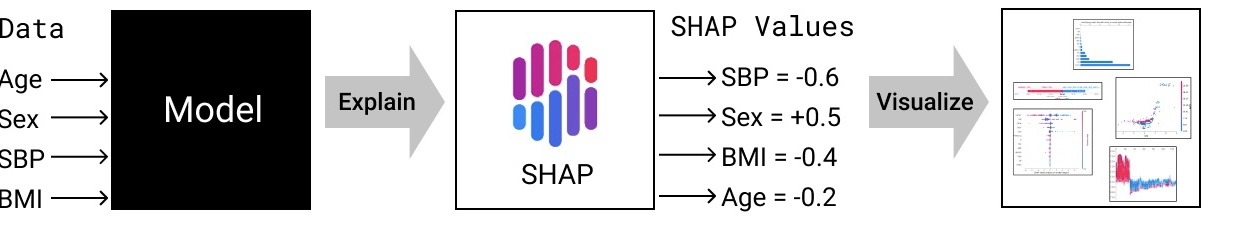
## **SHAP & ICE＋dtreeviz_回帰･二値分類データ対応**
データセットのアップロード後、前処理（簡易）、特徴量選択、SHAP & ICE表示、決定木分析（dtreeviz）を自動実行します。\
SHAPは機械学習モデルの予測値を各特徴量に分解、ICEは特徴量を変化させた時に機械学習モデルの予測値の影響を示すものなので、モデル精度に依存することを留意する必要があります。

**※簡易の前処理（不要データは基本削除）ではなく、欠損値や異常データを残したい等の前処理を行いたい場合は、コレ→ [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/hima2b4/Auto_Profiling/blob/master/Data_Preprosessing.ipynb) を実行してください。**

<details><summary>概要説明 :</summary><div>

- 回帰（Regression）・分類（Classification:**二値のみ**）データのいずれも実行可能です。（**Multiクラスには対応していません**）
- **結果に影響する特徴量との関係性をSHAP値による散布図やICE、決定木で示します**ので、**どのようなケースが結果に影響しているかが掴めます**。



<details><summary>dataset について : 
データをアップロードする場合は [ Upload ]を選択してください。Boston_housing :regression / Diabetes :regression / Breast_cancer :binary / Titanic :binary / Loan_prediction :binary はデータセットサンプルです。</summary><div>

- Boston_housing :regression　← ボストン市郊外の「犯罪発生率」や「広い部屋の割合」等と「住宅価格」の回帰データ。欠損値なし。すべてのカラムが数値のデータ。

- Diabetes :regression　← 糖尿病患者の「年齢」「性別」と「8項目の診断データ」と「1年後の進行度（数値）」の回帰データ。欠損値なし。「8項目の診断データ」は標本平均と標本分散で標準化（平均0, 標準偏差1）されている。

- Breast_cancer :binary　← 乳がんのさまざまな「診断データ」と「陽性・陰性（陽性:1, 陰性:0）」の二値分類データ。欠損値なし。すべてのカラムが数値のデータ。

- Titanic :binary　← タイタニック号 乗客者の「性別」「年齢」「チケットクラス」等と「生存情報（Survived）」のデータ。Survived：0（死亡）,1（生存）の二値分類。欠損値があり、文字列のカラムも複数あるデータ。

- Loan_prediction :binary　←　住宅ローン顧客の「性別」「配偶者の有無」「学歴」「扶養家族の数」「収入」「融資額」「クレジットヒストリー」などの情報と「ローン承認のStatus：Loan_Status(Y/N)」の二値分類データ。欠損値があり、文字列カラムも複数あるデータ。分類データである「Loan_Status」も 文字データ[Y,N] となっている。

- Upload　← 任意のデータセットを読み込む場合はこれを選択してください。
</div></details>
<details><summary>dataset_typeについて ：Classification（分類データ）か Regression（回帰データ）のいずれかを選択してください。</summary><div>

In [1]:
#@title **Select_Dataset** { run: "auto" }
dataset = 'Loan_prediction :binary' #@param ['Boston_housing :regression', 'Diabetes :regression', 'Breast_cancer :binary','Titanic :binary', 'Loan_prediction :binary', 'Upload']

#@title **Classification**（分類）or **Regression**（回帰）
dataset_type = 'Classification' #@param ["Classification", "Regression"]

### **ライブラリのインストール**

In [2]:
!pip install shap -q

     |████████████████████████████████| 564 kB 4.3 MB/s 


In [3]:
!pip install dtreeviz --quiet

     |████████████████████████████████| 61 kB 166 kB/s 


In [4]:
# ライブラリのインポート
import pandas as pd # 基本ライブラリ
import numpy as np # 基本ライブラリ
import matplotlib.pyplot as plt # グラフ描画用
import seaborn as sns; sns.set() # グラフ描画用
import warnings
warnings.filterwarnings('ignore')

### **Load dataset**



In [5]:
#@title **Load Dataset**
if dataset =='Upload':
  from google.colab import files
  uploaded = files.upload()#Upload
  target = list(uploaded.keys())[0]
  df = pd.read_csv(target)

elif dataset == "Diabetes :regression":
  from sklearn.datasets import load_diabetes
  dataset = load_diabetes()
  df = pd.DataFrame(dataset.data, columns=dataset.feature_names)
  df["target"] = dataset.target

elif dataset == "Breast_cancer :binary":
  from sklearn.datasets import load_breast_cancer
  dataset = load_breast_cancer()
  df = pd.DataFrame(dataset.data, columns=dataset.feature_names)
  df["target"] = dataset.target

elif dataset == "Titanic :binary":
  data_url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
  df = pd.read_csv(data_url)
  X = df.drop(['Survived'], axis=1) # 目的変数を除いたデータ
  y = df['Survived'] # 目的変数
  df = pd.concat([X, y], axis=1)

elif dataset == "Loan_prediction :binary":
  data_url = "https://github.com/shrikant-temburwar/Loan-Prediction-Dataset/raw/master/train.csv"
  df = pd.read_csv(data_url)

else:
  from sklearn.datasets import load_boston
  dataset = load_boston()
  df = pd.DataFrame(dataset.data, columns=dataset.feature_names)
  df["target"] = dataset.target

#X = pd.DataFrame(dataset.data, columns=dataset.feature_names)
#y = pd.Series(dataset.target, name='target')

source = df.copy()

FEATURES = df.columns[:-1]
TARGET = df.columns[-1]
X = df.loc[:, FEATURES]
y = df.loc[:, TARGET]

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [6]:
#@title **Datasetの数字・文字列区分**
numerical_col = []
Object_col = []

for col_name, item in df.iteritems():
    if item.dtype == object:
        Object_col.append(col_name)
    else:
        numerical_col.append(col_name)
        
print('-----------------------------------------------------------------------------------------')
print('Numerical_colomn:', numerical_col)
print('-----------------------------------------------------------------------------------------')
print('Object_colomn:', Object_col)
print('-----------------------------------------------------------------------------------------')
print('※ 前処理でカラムを指定する場合は、上記に表示されたカラムを Copy & Paste するとよい')

-----------------------------------------------------------------------------------------
Numerical_colomn: ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']
-----------------------------------------------------------------------------------------
Object_colomn: ['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Status']
-----------------------------------------------------------------------------------------
※ 前処理でカラムを指定する場合は、上記に表示されたカラムを Copy & Paste するとよい


### **前処理の選択**
<details><summary>実行できる前処理について</summary><div>

データセットに文字データや欠損値がある場合、決定木分析が実行できませんので、以下のような前処理メニューを設けています。
- **デフォルト設定**は、① 7割以上欠損値があるカラム（列）を削除、② カラム名に[ID][Lot]を含む列を削除、③ 欠損値がある行データを削除、④ 16進数データを10進数に変換、⑤ 文字列データをカテゴリー（数値）変換、⑥ 文字列データがあれば削除、⑦ 日本語カラムを英語翻訳 としています。
- ①～⑦は、実行する／しないが設定できます。
- **基本的には、上から順に実行するようにしてください。**（※先に③を実行すると多くのデータが削除されます。⑤は欠損値を削除する前に実行すると欠損値もカテゴリー化してしまいます。）
- 上記以外に、削除カラム（列）の個別指定、ラベルエンコーディングの個別指定も可能です。（※欠損値や文字列データが残っていると以降の処理でエラーとなりますので注意してください。）
- Uploadする**データに欠損値がなく、かつすべて数値データである場合、これら前処理は実行の対象となりませんので何も影響はありません。**
- ラベルエンコーディングは、例えば [優] [良] [可] [不可] を [0] [1] [2] [3] とする処理です。数値は 0～ 割り振られます。該当の前処理セル実行後、[優、良、可]等と表示されます。[優, 良, 可]＝[0, 1, 2] という対応になります。

In [7]:
#@title **削除する列を指定**
#@markdown  **<font color= "Crimson">注意</font>：指定は <u> ' ID ' , ' Age ' , </u> などとしてください。**</font>
Drop_label_is = '' #@param {type:"raw"}

try:
  if Drop_label_is is not "":
    Drop_label_is = pd.Series(Drop_label_is)
    df.drop(columns=list(Drop_label_is),axis=1,inplace=True)
  else:
    print('※削除カラムの指定なし→処理スキップ')
except:
    print("※正常に処理されませんでした。入力に誤りがないか確認してください。")

df.head()

※削除カラムの指定なし→処理スキップ


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [8]:
#@title **7割欠損値がある列を削除（☑ ＝実行）**
Over_70percent_missing_value_is_drop = True #@param {type:"boolean"}

#各列ごとに、6割欠損がある列を削除
if Over_70percent_missing_value_is_drop == True:
  for col in df.columns:
    nans = df[col].isnull().sum()  # nanになっている行数をカウント

    # nan行数を全行数で割り、7割欠損している列をDrop
    if nans / len(df) > 0.7: 
        # 7割欠損列を削除
        print('-----------------------------------------------------------------------------------------')
        print("drop column:", col)
        print('-----------------------------------------------------------------------------------------')
        df.drop(col, axis=1, inplace=True)    
#    else:
#      print(col,'：OK ⇒ 処理スキップ')
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [9]:
#@title **カラム名に [ID] [Lot] を含む列を削除（☑ ＝実行）**
Drop_ID_label = False #@param {type:"boolean"}

include_list = df.columns[df.columns.str.contains('ID|Lot',case=False)]

if Drop_ID_label == True:
  if include_list is not "":
    df.drop(columns=list(include_list),axis=1,inplace=True)
    print('-----------------------------------------------------------------------------------------')
    print("drop column:", list(include_list))
    print('-----------------------------------------------------------------------------------------')
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [10]:
#@title **欠損値がある行を削除（☑ ＝実行）**
Null_Drop  = True #@param {type:"boolean"}

if Null_Drop == True:
  df = df.dropna(how='any')
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
5,LP001011,Male,Yes,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,Y


In [11]:
#@title **HEX(16進数)列をINT(10進数)に変換（☑ ＝実行）**
HEX_to_INT  = False #@param {type:"boolean"}

import string
if HEX_to_INT == True:
  for col in df.columns:
    if df[col].dtype == 'object':
      if all(df[col].apply(lambda x: set(x).issubset(set(string.hexdigits)))) ==True:
        df[col]=df[col].apply(lambda x:int(x, 16))
#    else:
#      print(col,'=int →処理スキップ')
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
5,LP001011,Male,Yes,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,Y


In [12]:
#@title **Label encording する Obeject_col を指定**
#@markdown  **<font color= "Crimson">注意</font>：指定は <u> ' ID ' , ' Age ' , </u> などとしてください。**
Object_label_to_encode_is = '' #@param {type:"raw"}

from sklearn.preprocessing import LabelEncoder

encoders = dict()

try:
  for i in Object_label_to_encode_is:
    if Object_label_to_encode_is is not "":
      series = df[i]
      le = LabelEncoder()
      df[i] = pd.Series(
        le.fit_transform(series[series.notnull()]),
        index=series[series.notnull()].index
        )
      encoders[i] = le
      print('-----------------------------------------------------------------------------------------')
      print('[エンコードカラム]：',i)
      le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
      print(le_name_mapping)
    else:
      print('skip')

except:
    print("※正常に処理されなかった場合は入力に誤りがないか確認してください。")
print('-----------------------------------------------------------------------------------------') 
df.head()

-----------------------------------------------------------------------------------------


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
5,LP001011,Male,Yes,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,Y


In [13]:
#@title **すべての Obeject_col を Label encord（☑ ＝実行）**
Encord_all_object_label = True #@param {type:"boolean"}

if Encord_all_object_label == True:
  le = LabelEncoder()

  for col in df.columns:
    if df[col].dtype == 'object':
      df[col] = le.fit_transform(df[col].astype(str))
      print('-----------------------------------------------------------------------------------------') 
      print(col)
      print(le.classes_, "= [0, 1, 2...]" )
     
#    else:
#      print(col,'：エンコードしない→処理スキップ')

print('-----------------------------------------------------------------------------------------') 
df.head()

-----------------------------------------------------------------------------------------
Loan_ID
['LP001003' 'LP001005' 'LP001006' 'LP001008' 'LP001011' 'LP001013'
 'LP001014' 'LP001018' 'LP001020' 'LP001024' 'LP001028' 'LP001029'
 'LP001030' 'LP001032' 'LP001036' 'LP001038' 'LP001043' 'LP001046'
 'LP001047' 'LP001066' 'LP001068' 'LP001073' 'LP001086' 'LP001095'
 'LP001097' 'LP001098' 'LP001100' 'LP001112' 'LP001114' 'LP001116'
 'LP001119' 'LP001120' 'LP001131' 'LP001138' 'LP001144' 'LP001146'
 'LP001151' 'LP001155' 'LP001157' 'LP001164' 'LP001179' 'LP001186'
 'LP001194' 'LP001195' 'LP001197' 'LP001198' 'LP001199' 'LP001205'
 'LP001206' 'LP001207' 'LP001222' 'LP001225' 'LP001228' 'LP001233'
 'LP001238' 'LP001241' 'LP001243' 'LP001245' 'LP001248' 'LP001253'
 'LP001255' 'LP001256' 'LP001259' 'LP001263' 'LP001265' 'LP001267'
 'LP001275' 'LP001279' 'LP001282' 'LP001289' 'LP001310' 'LP001316'
 'LP001318' 'LP001319' 'LP001322' 'LP001325' 'LP001327' 'LP001333'
 'LP001334' 'LP001343' 'LP00134

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
1,0,1,1,1,0,0,4583,1508.0,128.0,360.0,1.0,0,0
2,1,1,1,0,0,1,3000,0.0,66.0,360.0,1.0,2,1
3,2,1,1,0,1,0,2583,2358.0,120.0,360.0,1.0,2,1
4,3,1,0,0,0,0,6000,0.0,141.0,360.0,1.0,2,1
5,4,1,1,2,0,1,5417,4196.0,267.0,360.0,1.0,2,1


In [14]:
#@title **すべての文字列データを削除（☑ ＝実行）**
Exclude_Object = True #@param {type:"boolean"}

#数値の列は残し、文字列だけを削除
if Exclude_Object == True:
  df = df.select_dtypes(exclude='object')

df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
1,0,1,1,1,0,0,4583,1508.0,128.0,360.0,1.0,0,0
2,1,1,1,0,0,1,3000,0.0,66.0,360.0,1.0,2,1
3,2,1,1,0,1,0,2583,2358.0,120.0,360.0,1.0,2,1
4,3,1,0,0,0,0,6000,0.0,141.0,360.0,1.0,2,1
5,4,1,1,2,0,1,5417,4196.0,267.0,360.0,1.0,2,1


In [15]:
#@title **カラム名を英訳（☑ ＝実行）**
Column_English_translation = False #@param {type:"boolean"}

if Column_English_translation == True:
  !pip install googletrans==4.0.0-rc1 --quiet
  from googletrans import Translator

  eng_columns = {}
  columns = df.columns
  translator = Translator()
  
  for column in columns:
    eng_column = translator.translate(column).text
    eng_column = eng_column.replace(' ', '_')
    eng_columns[column] = eng_column
    df.rename(columns=eng_columns, inplace=True)

print('-----------------------------------------------------------------------------------------')
print('[カラム名_英訳結果（翻訳しない場合も表示）]')
print('-----------------------------------------------------------------------------------------') 
df.head(0)

-----------------------------------------------------------------------------------------
[カラム名_英訳結果（翻訳しない場合も表示）]
-----------------------------------------------------------------------------------------


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status


### **SHAP & ICE** ～特徴量と予測値の関係～
**SHAP**は、機械学習モデルが 「なぜその予測値を出したのか」 を各特徴量の貢献度に分解して解釈できます。
**ICE**は、各特徴量がモデルの予測値にどのように影響を与えているのかを確認できます。

※**SHAP**は「なぜモデルがこの予測値を出したのか｣、**ICE**は「特徴量が変化した際に予測値がどう反応するのか」


In [16]:
#@title **SHAP summary plot**

import xgboost as XGB
import shap

#X,yを再セット
FEATURES = df.columns[:-1]
TARGET = df.columns[-1]
X = df.loc[:, FEATURES]
y = df.loc[:, TARGET]


#testとtrainを分割
from sklearn.model_selection import train_test_split

if dataset_type == 'Classification':
  X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1, stratify = y)
else:
  X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1, test_size=0.5)


#XGB
if dataset_type == 'Regression':
  xgb = XGB.XGBRegressor(random_state=0,objective='reg:squarederror')
else:
  xgb = XGB.XGBClassifier(random_state=0)

xgb.fit(X, y)

xgb.fit(X_train,y_train)
print('-----------------------------------------------------------------------------------------')
print('Score of train with XGB :\t %1.3f' % xgb.score(X_train,y_train))
print('Score of test with XGB :\t %1.3f' % xgb.score(X_test, y_test))
print('-----------------------------------------------------------------------------------------')


#SHAP
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X)

"""※check_additivityについて
TreeExplainerでAdditivityチェックのエラーとともに、説明器に渡したデータ行列
がモデルが学習されたものと同じ形状であることを確認してくださいと示された場合、
shap_values = explainer.shap_values(X, check_additivity=False) 
とすることで解消されるようである。
"""

#各カラムのmean_SHAPをdf2に格納
vals = np.abs(shap_values).mean(0)
feature_names = X.columns

if vals.ndim == 1:
  df2 = pd.DataFrame(list(zip(feature_names, vals)),columns=['col_names','mean_SHAP'])
else:
  vals2 = vals.sum(axis=1)
  df2 = pd.DataFrame(list(zip(feature_names, vals2)),columns=['col_names','mean_SHAP'])

#https://github.com/slundberg/shap/issues/632

"""mean_SHAPの算出
#Randamforestを学習モデルとした際は、RegressionのSHAP値は1×n、Classificationは二値ならば
2×n であったため、mean_SHAPの算出は Regressionの場合はvalsを与え、Classificationの場合は
vals.sum = val2を与えていたが、xgbを学習モデルとすると出力次元が異なり、エラーとなった。
このため、vals.ndimで次元数を確認し、1か、2以上かで処理を区分している。
"""

#SHAPの結果をマージ(rankを文字化,ソート)

df2 = df2.sort_values('mean_SHAP',ascending=False)
df2 = df2.reset_index(drop=True)

df2


-----------------------------------------------------------------------------------------
Score of train with XGB :	 0.894
Score of test with XGB :	 0.817
-----------------------------------------------------------------------------------------


,col_names,mean_SHAP
0,Credit_History,0.783321
1,LoanAmount,0.345374
2,Property_Area,0.317645
3,Loan_ID,0.303039
4,CoapplicantIncome,0.224582
5,ApplicantIncome,0.214466
6,Married,0.150178
7,Loan_Amount_Term,0.110421
8,Dependents,0.095736
9,Gender,0.009656


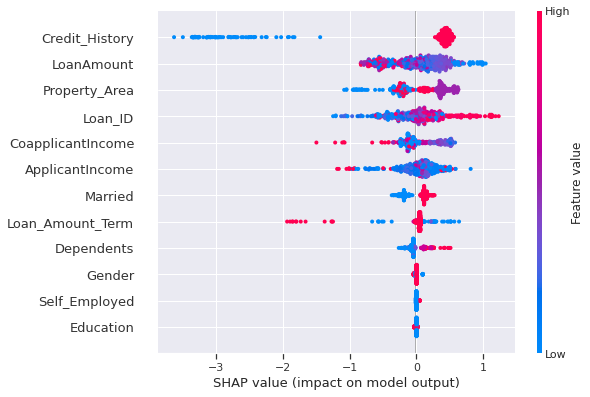

In [17]:
#@title **SHAP summary plot**
#@markdown ※特徴量の値が大きくなる方向は赤、小さくなる方向は青
try:
  shap.summary_plot(shap_values,X)
except:
  pass

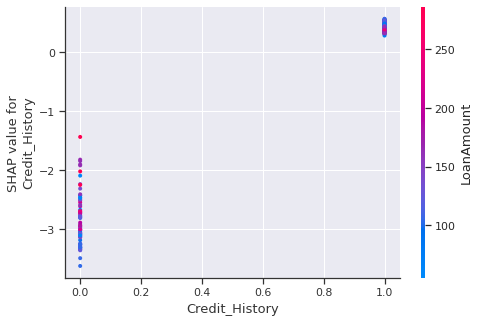

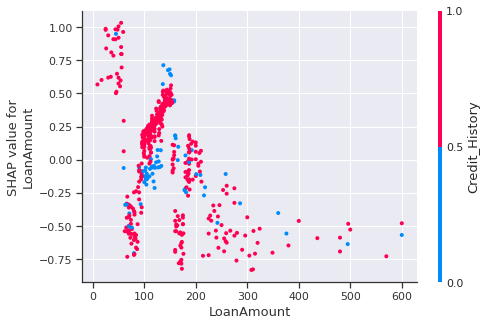

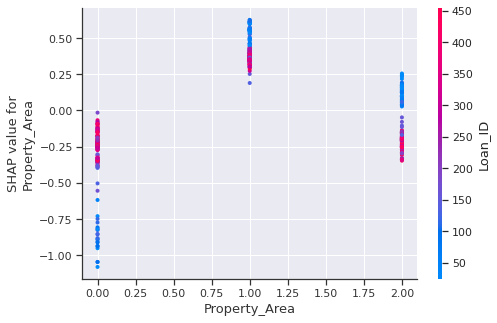

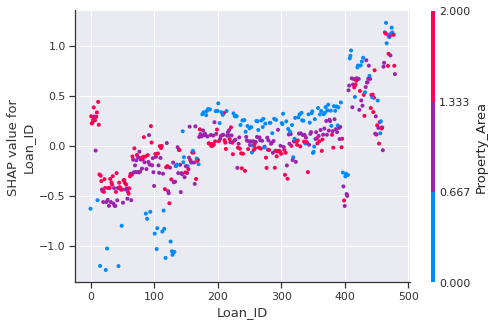

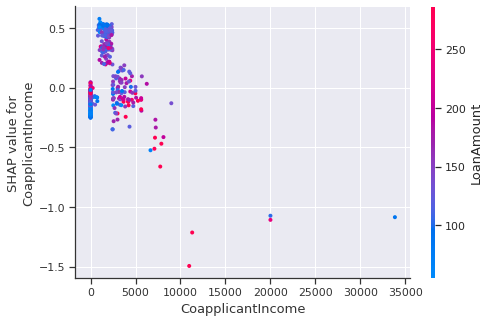

In [18]:
#@title **SHAP scatter plot**（feature[X] vs. SHAP[y]｜表示数設定：2～10）{ run: "auto" }
#X軸にその特徴の値、Y軸に同じ特徴のSHAP値をプロット。モデルが与えられた特徴にどのように依存するかを示す。垂直方向の分散は相互作用効果を表す。

Number_of_graphs_shown = 5 #@param {type:"slider", min:2, max:10, step:1}

try:
  for i in range(Number_of_graphs_shown):
    shap.dependence_plot(df2['col_names'][i], shap_values, X)
except:
  pass


In [19]:
#@title **SHAP force plot**
#@markdown ※sample order by similarity（近似値順）｜sample order by output value（出力値順）｜original sample ordering（オリジナルサンプル順序）

#@markdown ※model予測結果 ＝ model基礎スコア（explainer.expected_value）＋ 特徴量毎のSHAP値（shap_values）

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, X)


-----------------------------------------------------------------------------------------
Score of train with RandomForest :	 0.855
Score of test with RandomForest :	 0.352
-----------------------------------------------------------------------------------------


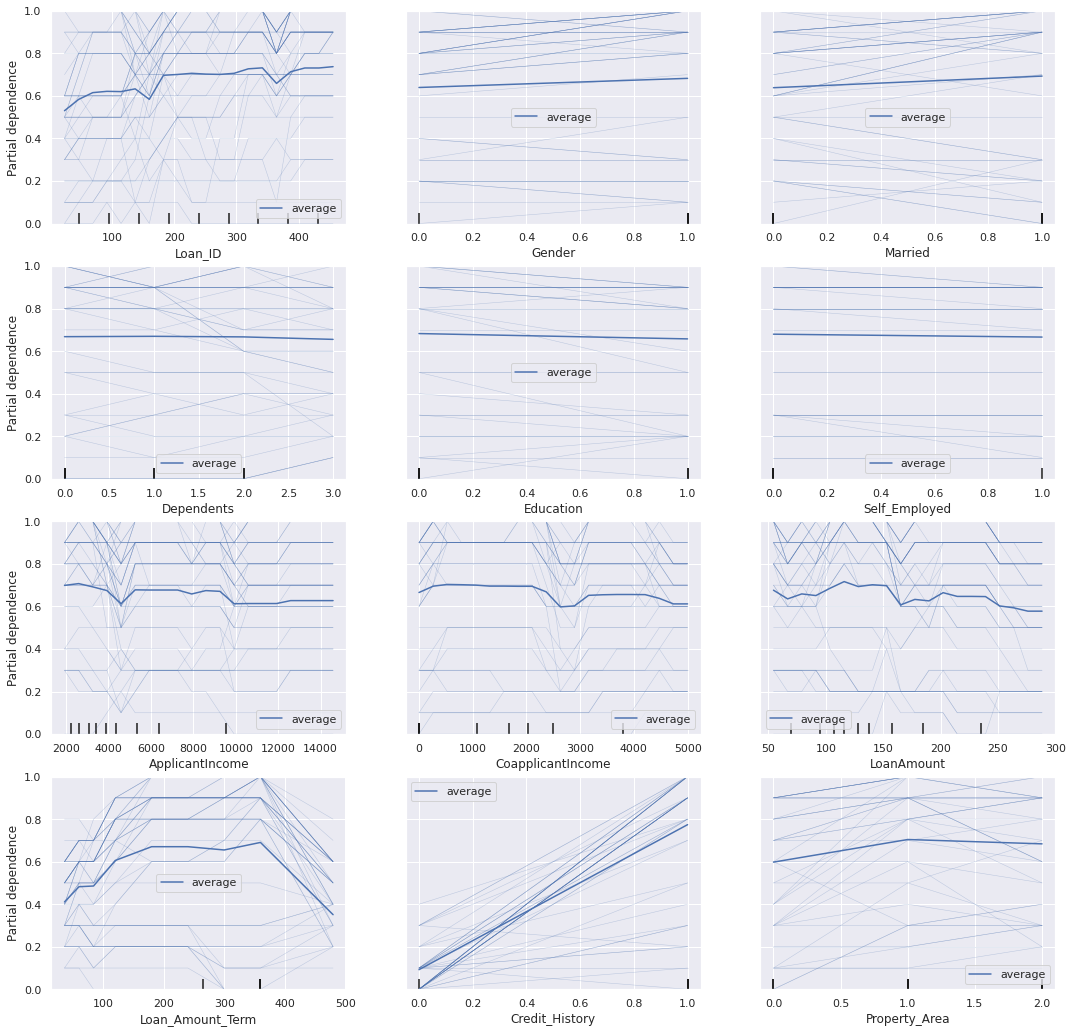

In [20]:
#@title **ICE Plot ～RandamForest～**
#@markdown それぞれの特徴量がモデルの予測値にどのように影響を与えているかが確認できます。

from sklearn.inspection import plot_partial_dependence
from sklearn.ensemble import RandomForestRegressor

#RandomForest
features = X.columns
est = RandomForestRegressor(n_estimators=10)
est.fit(X, y)

est.fit(X_train,y_train)
print('-----------------------------------------------------------------------------------------')
print('Score of train with RandomForest :\t %1.3f' % est.score(X_train,y_train))
print('Score of test with RandomForest :\t %1.3f' % est.score(X_test, y_test))
print('-----------------------------------------------------------------------------------------')

#表示グラフ数に応じsubplotサイズ変更
if len(X.columns) >= 20:
  size=40
elif len(X.columns) >= 15:
  size=23
else:
  size=18

#ICE表示
fig, ax = plt.subplots(figsize=(18, size))
plot_partial_dependence(
    est,
    X,
    features,
    kind="both",
    subsample=50,
    n_jobs=3,
    grid_resolution=20,
    random_state=0,
    ax=ax)


### **Desision Tree**
<details><summary>Decision tree について</summary><div>
決定木はシンプルなほど解釈しやすくなりますので、まずは可読性を重視した決定木を出力するようにしています。（木の深さは2～6に任意設定できます）

※以下、Noteではデータを訓練用とテスト用に分割し、パラメーターチューニングにより最適化を図った条件で描いたDesicionTreeも表示させるようにしています。

*   #orientation='LR' の # を消すと、決定木の表示は横向きになります。
*   予測したいXの値を X=[X1,X2,X3,X4,…] とすると予測値が表示されます。

-----------------------------------------------------------------------------------------
[最適パラメータ]
DecisionTreeClassifier(max_depth=1, random_state=0)
-----------------------------------------------------------------------------------------
Confusion matrix
[[19 18]
 [ 1 82]]
Classification report
              precision    recall  f1-score   support

           0       0.95      0.51      0.67        37
           1       0.82      0.99      0.90        83

    accuracy                           0.84       120
   macro avg       0.89      0.75      0.78       120
weighted avg       0.86      0.84      0.83       120

-----------------------------------------------------------------------------------------


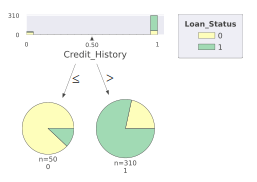

In [21]:
#@title **DecisionTree**（GridSearchによるパラメータ最適化Ver.）

#dtreeviz import
from dtreeviz.trees import *

'''
#testとtrainを分割
from sklearn.model_selection import train_test_split

if dataset_type == 'Classification':
  X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1, stratify = y)
else:
  X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1, test_size=0.5)
'''

#ライブラリインポート
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

#GridSearch実行
if dataset_type == 'Classification':
  dtr = DecisionTreeClassifier(random_state=0)
else:
  dtr = DecisionTreeRegressor(random_state=0)

gs_dtr = GridSearchCV(dtr,
                      param_grid = {'max_depth': [1, 2, 3, 4, 5, 6, 7],
                      'min_samples_leaf':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
                      cv = 10)

gs_dtr.fit(X_train, y_train)

#パラメータ最適化 ⇒ DecisionTree出力
if dataset_type == 'Classification':
  viz = dtreeviz(gs_dtr.best_estimator_,
               X_train,
               y_train,
               target_name = TARGET,
               feature_names = FEATURES,
               fontname='DejaVu Sans',
               #orientation='LR',
               #X = [3,3,5,3],
               class_names = list(y.unique())
              )
else:
  viz = dtreeviz(gs_dtr.best_estimator_,
               X_train,
               y_train,
               target_name = TARGET,
               feature_names = FEATURES,
               fontname='DejaVu Sans',
               #orientation='LR',
               #X = [3,3,5,3]
              )

from sklearn.metrics import r2_score   # 決定係数
from sklearn.metrics import mean_squared_error  # RMSE
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report  #classification report

print('-----------------------------------------------------------------------------------------')
print('[最適パラメータ]')
print(gs_dtr.best_estimator_)
print('-----------------------------------------------------------------------------------------')

# 予測値
y_train_pred = gs_dtr.predict(X_train)
y_test_pred = gs_dtr.predict(X_test)

if dataset_type == 'Classification':
  print('Confusion matrix')
  print(confusion_matrix(y_test, y_test_pred))
  print('Classification report')
  print(classification_report(y_true=y_test, y_pred=y_test_pred))

else:
  print('Regression report')
  print(' RMSE\t train: %.2f,\t test: %.2f' % (
      mean_squared_error(y_train, y_train_pred, squared=False), 
      mean_squared_error(y_test, y_test_pred, squared=False)))
  print(' MAE\t train: %.2f,\t test: %.2f' % (
      mean_absolute_error(y_train, y_train_pred), 
      mean_absolute_error(y_test, y_test_pred)))
  print(' R²\t train: %.2f,\t test: %.2f' % (
        r2_score(y_train, y_train_pred), # 学習
        r2_score(y_test, y_test_pred)    # テスト
      ))
print('-----------------------------------------------------------------------------------------')

viz

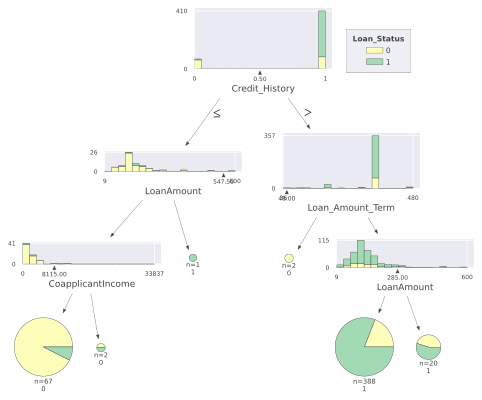

In [22]:
#@title **Desision Tree**（決定木 深さ設定｜max_depth：2～6｜☑ ＝実行） { run: "auto" }
#Display_decision_tree = True #@param {type:"boolean"}

max_depth = 3 #@param {type:"slider", min:2, max:6, step:1}


if dataset_type == 'Classification':
  CLASS_NAME = list(y.unique())
  dtree = tree.DecisionTreeClassifier(max_depth=max_depth)
  dtree.fit(X,y)
  viz = dtreeviz(dtree,X,y,
               target_name = TARGET,
               feature_names = FEATURES,
               #orientation='LR',
               class_names = CLASS_NAME,
               fontname='DejaVu Sans',
               #X = [3,3,3,5,3]
              )

if dataset_type == 'Regression':
  dtree = tree.DecisionTreeRegressor(max_depth=max_depth)
  dtree.fit(X,y)
  viz = dtreeviz(dtree,X,y,
               target_name = TARGET,
               feature_names = FEATURES,
               fontname='DejaVu Sans',
               #orientation='LR',
               #X = [3,3,5,3]
              )

#if Display_decision_tree == True:
#  viz

viz

In [23]:
#@title **Decision tree 画像出力（☑ ＝実行）**  { run: "auto" }

Decision_tree_best_output = False #@param {type:"boolean"}
Decision_tree_output = False #@param {type:"boolean"}

if Decision_tree_output == True:
  viz.save('Decission_tree_result.svg')

if Decision_tree_best_output == True:
  viz.save('Decission_tree_best_result.svg')

### **Note**

**Borutaについて**

 Borutaは、Witold R. Rudnicki, Miron B. Kursaらが考案したランダムフォレストと検定を用いた特徴量選択の方法。 

Borutaは、以下を実行。
- 各特徴量をランダムにシャッフル（シャドウ特徴量と呼ぶ）した別のデータフレームを元のデータフレームに結合したデータフレームを作成。
- 目的変数y にてランダムフォレストを実行。
- シャドウ特徴量のなかでもっとも高い特徴量重要度を閾値とし、元の各特徴量の特徴量重要度と比較、閾値よりも高い特徴量重要度を持つ特徴量を有用な特徴量と判定。
- 二値判定（当たるか当たらないか）は二項分布に従い、二項分布は試行回数nを増やすと正規分布に近似する。この性質を利用し、100回試行で検定し、以下3領域に判別する。
>Rejected：特徴量はノイズと判断され、削除される。\
>Tentative：判断は保留される。（選択の対象とはされない）\
>Accepted：特徴量は予測可能であると判断され、選択される。

![boruta](https://miro.medium.com/max/1094/1*yqAUlMtPUiFyr8gYLFagTA.png)
[※Boruta Explained Exactly How You Wished Someone Explained to You より引用](https://towardsdatascience.com/boruta-explained-the-way-i-wish-someone-explained-it-to-me-4489d70e154a)

******
  
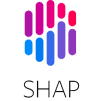

**SHAPについて**

SHAP：SHapley Additive exPlanations

- SHAP（SHapley Additive exPlanations）は、協力ゲーム理論のシャープレイ値（Shapley Value）を機械学習に応用したオープンソースのライブラリです。
モデルの予測結果に対する各変数（特徴量）の寄与を求めるための手法で、**特徴量の増減が結果に与える影響を可視化することができます。** 
機械学習モデルは、どのような仕組みで計算がされているのかを理解することが難しいことからブラックボックスモデルと呼ばれますが、**SHAPは機械学習モデルの振る舞いを解釈**することができます。

- シャープレイ値というのは、協力ゲーム理論において複数プレイヤーの協力によって得られた利得を各プレイヤーに公正に分配するための手段の一つです。「プレイヤーが新たにゲームに加わることにより賞金がいくら増えるか」を表す限界貢献度（marginal contribution）を用いています。限界貢献度はプレイヤーがどの順番でゲームに加わるかで異なるので、すべての組合せで求められます。シャープレイ値はその期待値（平均値）です。
この考えを機械学習に適用し、各特徴量がモデルの予測値に与える貢献度をシャープレイ値で表せるようにしたのがSHAPです。

- SHAPは、機械学習モデルの出力結果に対して各特徴量がどれだけ影響を与えたかを算出する手法なので、モデルの振る舞い、いわば特徴量と予測値の関係性をストレートに把握することができます。
特徴量と予測値の因果関係まで示してくれるものではありませんし、モデルの出力結果から導くので信頼度はモデル精度に依存することを意識しておく等を必要はありますが、複雑なデータセットからインサイトを得る助けとなるでしょう。
　

**Feature selected  result**

- 「Feature selected  result」は、Borutaと SHAPの結果を結合したグラフです。グラフの縦軸（mean_SHAP）は各特徴量のSHAP値の平均です。

**SHAP summary plot**

- 全サンプルのSHAP値を各特徴量ごとにプロットしたものです。色が説明変数の値の大小を、プロットの位置がSHAP値の大小を表します。縦軸の特徴量は、重要度順に表示されます。上にあるほど重要な特徴量です。このグラフで各特徴量についてSHAP値の平均をとったものが先の「Feature selected  result」のmean_SHAPになります。
- SHAP値は予測値に対する特徴量の寄与を示すものなので、特徴量(X軸)が変化したら予測値がどう変化するかが読み取れます。（2次的な傾向の存在、変化の臨界点の有無等）
- また、特徴量(X軸)と他の特徴量との相互作用も確認できます。他の特徴量＝第2縦軸の特徴量であり、これは自動的に適した特徴量(変数)が選択されています。選択された特徴量の大小によって、同じ特徴量(X軸)でもSHAP値が異なる等が読み取れます。
- 重要度が高い特徴量から順に散布図を自動表示します。表示数はバー設定により2～10の範囲で設定できます。（特徴量数が少ない場合は表示数限界までしか表示しません）

**Dependence plot**

- Dependence plotは、横軸に特徴量の実際の値、縦軸にSHAP値が取られています。単一の特徴量がどのように予測結果に影響しているかが把握できます。また、別の特徴量との交互作用を確認することもできます。

**force plot**

- force plotは、全レコードのSHAP値の傾向を確認することができます。データセット内のすべての例について、特徴量のSHAP値と特徴量の値をがプロットされます。Order By Similarityとすると、特徴量の分布が似た者通しで並べてくれます。SHAP値で並び替えることもできます。

***

**ICE plot**

ある特徴の値の変化が機械学習モデルの予測にどのような影響を与えるかを可視化するPDP（Partial Dependence Plot）を拡張したもの。
PDPは興味のある変数以外の影響を周辺化（一定に保つ）により消し、注目したい特徴量の値を変化させたときの予測結果をプロットする。
PDPは予測値を平均化するが、この場合、 インスタンスごとの異質性に気づくことができない。 ICEは、あるインスタンスの特徴値を変化させた場合の予測値をを1つのプロットにまとめて表示するのでインスタンスの部分集合間の関係や個々のインスタンスの振る舞いの違いを見ることができるというもの。

https://dropout009.hatenablog.com/entry/2019/01/07/124214


**評価指標について**

回帰モデル：R² > 0.5 が精度の目安。以下は回帰モデルの代表的な評価指標。
- RMSE（Root Mean Squared Error）：回帰問題の代表的な評価指標。平均二乗誤差 （Mean Squared Error MSE）の平方根をとることで目的変数とスケールを合わせている。低ければ低いほどよく、最良の場合 0 になる。観測値と予測値の差が大きいとRMSEは大きくなるので、外れ値の影響を受けやすい。
- MAE（Mean Absolute Error）：観測値と予測値の差の絶対値の平均。0以上の値をとり、小さいほどよい。外れ値に対しては影響を受けるがRMSEよりは強い。
- R²（決定係数）：「平均値による予測」と比べて「モデルによる予測｣によって予測誤差がどの程度改善しているかを表す指標。平均値では説明できなかった目的変数のばらつきのうちモデルの予測によってどの程度を説明できるようになったかを表していることからモデルがデータをどの程度説明できているのかを割合で示す指標といえる。RMSE とは違い大きいほど予測精度が高いモデルといえる。R²は基本的には0から1の値をとる。極端な例として、 完全に予測ができている場合は R² = 1となり、逆に、平均と同じくらいの精度でしか予測できない場合は R² = 0となる。なお、単に平均で予測するよりも予測モデルの精度が悪い場合は、R²はマイナスとなる。
この指標を最大化することはRMSEを最小化することと同じ意味。

***
分類モデル：適合率と再現率のどちらの優先度が高いかを判断しつつ、優先度が低い方はどの程度ならば許容できるか、評価指標をバランスよくとらえる。
- Confusion matrix：予測と実際の分類を行列形式にまとめたもの。センサでいえば、誤動作と失報のいずれを重視するかということがある。このような場合、トータル指標である正解率だけでは判断できないことに注意。

|       | 予測_Negative | 予測_Positive | |
|:------|---------|---------|---------|
| 実際_Negative |TN (True Negative) |FP (False Positive) | |
| 実際_Positive |FN (False Negative)  |TP (True Positive) | 再現率: TP/(TP+FN) |
| |  | 適合率: TP/(TP+FP)| 正解率|

- 正解率（Accuracy）：全予測に対する正答率。
- 適合率（Precision）：正と予測したデータのうち、実際に正であるものの割合。
- 再現率（Recall）：実際に正であるもののうち、正であると予測されたものの割合。
- F値（F-measure）：適合率と再現率の調和平均。

**参考サイト**
- [AIを理解する技術ーSHAPの原理と実装ー](https://note.com/dd_techblog/n/n18d354b4defa)
- [SHAP値で機械学習モデルの予測結果の解釈性を高める](https://cpptake.com/archives/608)
- [Borutaによる特徴量の選択を理解する](https://yaakublog.com/boruta_feature_selection)
- [Boruta Github](https://github.com/scikit-learn-contrib/boruta_py)
- [Get a feature importance from SHAP Values](https://stackoverflow.com/questions/65534163/get-a-feature-importance-from-shap-values)
- [how to extract the most important feature names ?](https://github.com/slundberg/shap/issues/632)
